# Introduction
Predict new CommGroup codes based on sub-major and supplier

work based on [ref](https://towardsdatascience.com/random-forest-in-python-24d0893d51c0)



### Imports
Import libraries and write settings here.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Visualizations
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (20,15)

### Load data
Load data here

In [2]:
df = pd.read_csv('../data/item_model_20200620.txt', sep='\t', engine='python')

In [3]:
# convert $(5) to -5
df['Est12MoSales'] = df['Est12MoSales'].replace( '[\$,)]','', regex=True ).replace( '[(]','-',   regex=True ).astype(float)

In [4]:
# remove bad data
df.dropna(inplace=True)

# remove unneeded data
df.comm_group_cd = df.comm_group_cd.str.upper();
df = df[df.comm_group_cd != 'ITMEPS']
df = df[df.comm_group_cd != 'ITMFRT']
df = df[df.ItemStatus != 'P']
df = df[df.SubMajorProdClass != '***-**']

# cleanup formatting
df.Supplier = df.Supplier.str.rstrip()
df.SalesCategory = df.SalesCategory.str.rstrip()
df.comm_group_cd = df.comm_group_cd.str.rstrip()
df.SubMajorProdClass = df.SubMajorProdClass.str.rstrip()

# set target to integer-based category
df.comm_group_cd = df.comm_group_cd.astype('category')

# make firt of any group the most important
df.sort_values(by='Est12MoSales', ascending=False, inplace=True)

# Analysis
What goes in the model?

In [5]:
df.head()

ItemKey        Item                 ItemDescription Supplier  \
115612   108067  5840186     Annual PMA Equal Month Billing   REPAIR   
142778   223090  5878777                 Cerec Primescan TP   SIRCER   
4153       4128  1019778                      Labour Charge   REPAIR   
69637     63058  4929044            A-dec 511 Patient Chair     ADEC   
195720   174889  7770136             Filtek Supreme A2B Cap   3MDENT   

       ItemStatus Label StockingType SalesCategory MajorProductClass  \
115612          A     B            N        SERVIC               820   
142778          A     B            N        HITECH               826   
4153            A     B            N        SERVIC               820   
69637           A     B            N        EQUIPM               800   
195720          A     B            S         MERCH               004   

       SubMajorProdClass MinorProductClass  Est12MoSales comm_group_cd  
115612            820-03         820-03-01   10219697.05        ITMSER  
142778            826-02         826-02-01    6484883.75        DIGCIM  
4153              820-01         820-01-**    4644285.99        ITMSER  
69637             800-04         800-04-01    3507180.42        ITMFO1  
195720            004-01         004-01-10    3179724.76        ITMSND

In [6]:
print(df.comm_group_cd.value_counts())
print(df.SalesCategory.value_counts())

ITMSND    65489
ITMPAR    39869
ITMFO2     5503
ITMFO1     4966
DIGMAT     3912
ITMFO3     3208
ITMEQ0     2999
ITMCAM     2008
ITMCPU      918
DIGIMP      781
ITMTEE      644
ITMSOF      155
DIGCIM       66
ITMISC       66
ITMSER       42
DIGLAB       28
SPMSND       13
DIGCCS       12
Name: comm_group_cd, dtype: int64
MERCH     72598
PARTS     39923
EQUIPM     9260
SMEQU      2826
HITECH     2193
CAMLOG     1917
ITS         917
TEETH       693
OTHER       197
DENTRX       93
SERVIC       48
VALADD        8
DNU           4
CEHP          2
Name: SalesCategory, dtype: int64


### tree based on submajor and supplier
weight by sales?

In [7]:
df_features = df.loc[:,['SubMajorProdClass', 'Supplier']]
#df_features = df.loc[:,['SalesCategory', 'SubMajorProdClass', 'Supplier']]
df_features_dummy = pd.get_dummies(df_features)

In [8]:
# Labels are the values we want to predict
labels = np.array(df['comm_group_cd'].cat.codes)
# Saving feature names for later use
feature_list = list(df_features_dummy.columns)
# Convert to numpy array
features = np.array(df_features_dummy)

In [9]:
labels_dict = dict( enumerate(df['comm_group_cd'].cat.categories ) )
labels_dict_rev = dict(zip(labels_dict.values(), labels_dict.keys()))

# Modelling

In [10]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

In [11]:
# Split the data into training and testing sets.  Use stratify to account for heavy weighting of parts and merch
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42, stratify=labels)

In [12]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (98009, 1892)
Training Labels Shape: (98009,)
Testing Features Shape: (32670, 1892)
Testing Labels Shape: (32670,)


### baseline
Merch = ITMSND
(better if Parts = ITMPAR
else = ITMFO3)

In [13]:
# create simple baseline
df_baseline = df.drop_duplicates(subset=['SubMajorProdClass', 'Supplier'])[['SubMajorProdClass', 'Supplier', 'comm_group_cd']]
df_baseline.rename(columns={'comm_group_cd': 'comm_group_cd_baseline'}, inplace=True)
df = df.merge(df_baseline, on=['SubMajorProdClass', 'Supplier'])

In [14]:
#baseline error
baseline_accuracy = (df['comm_group_cd'] == df['comm_group_cd_baseline']).mean()
print('baseline accuracy percent: ', round(100* np.mean(baseline_accuracy), 1))

baseline accuracy percent:  93.6


### train model

#### pre-select important features

In [15]:
important_indices = [feature_list.index('SalesCategory_PARTS')
,feature_list.index('SalesCategory_MERCH')
,feature_list.index('Supplier_ADEC')
,feature_list.index('SubMajorProdClass_805-21')
,feature_list.index('Supplier_MCC')
,feature_list.index('SubMajorProdClass_904-**')
,feature_list.index('Supplier_ACESUR')
                     
,feature_list.index('Supplier_PLANME')
,feature_list.index('SubMajorProdClass_800-52')
,feature_list.index('SubMajorProdClass_845-05')
,feature_list.index('SubMajorProdClass_845-06')
,feature_list.index('SalesCategory_CEHP')
,feature_list.index('SalesCategory_CAMLOG')
,feature_list.index('SalesCategory_VALADD')
,feature_list.index('SalesCategory_ITS')
,feature_list.index('SalesCategory_SERVIC')
                  
,feature_list.index('SalesCategory_HITECH')
,feature_list.index('SubMajorProdClass_855-01')
,feature_list.index('SalesCategory_EQUIPM')
,feature_list.index('Supplier_MIDMAK')
,feature_list.index('SubMajorProdClass_805-70')
,feature_list.index('SalesCategory_TEETH')
,feature_list.index('Supplier_DCI')
,feature_list.index('SubMajorProdClass_076-90')
,feature_list.index('SubMajorProdClass_073-01')
,feature_list.index('Supplier_SIRONC')
,feature_list.index('Supplier_KAVODG')
,feature_list.index('SalesCategory_SMEQU')
,feature_list.index('SubMajorProdClass_805-25')
,feature_list.index('SubMajorProdClass_023-81')
,feature_list.index('Supplier_SHENZH')
,feature_list.index('SubMajorProdClass_845-99')
,feature_list.index('SubMajorProdClass_805-45')
,feature_list.index('Supplier_GLIDE')
,feature_list.index('SubMajorProdClass_800-04')
,feature_list.index('Supplier_NSKAMR')
,feature_list.index('SubMajorProdClass_372-07')
,feature_list.index('Supplier_TALLAD')
,feature_list.index('SubMajorProdClass_821-01')
,feature_list.index('SubMajorProdClass_373-01')
,feature_list.index('SubMajorProdClass_372-02')
,feature_list.index('Supplier_SCORE')
,feature_list.index('SubMajorProdClass_071-01')
,feature_list.index('Supplier_CAIRTE')
,feature_list.index('SubMajorProdClass_800-10')
,feature_list.index('SubMajorProdClass_800-02')
,feature_list.index('Supplier_SIRCER')
,feature_list.index('Supplier_DENTPL')
,feature_list.index('SubMajorProdClass_800-09')
,feature_list.index('SubMajorProdClass_021-01')
,feature_list.index('Supplier_AMAGIR')
,feature_list.index('SubMajorProdClass_010-05')
,feature_list.index('Supplier_DENTZA')
,feature_list.index('SubMajorProdClass_805-10')
,feature_list.index('SubMajorProdClass_023-26')
,feature_list.index('Supplier_HSCAT')
,feature_list.index('SubMajorProdClass_074-05')]

ValueError: 'SalesCategory_PARTS' is not in list

train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

#### setup estimator based on feature set 

In [16]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
# Important / full
#rf = RandomForestClassifier(n_estimators = 1000, warm_start=True, criterion='entropy', random_state = 42)
rf = RandomForestClassifier(n_estimators = 10, warm_start=True, criterion='entropy', random_state = 42, max_depth = 5)


In [17]:
# Train the model on training data
# important / full
#%time rf.fit(train_important, train_labels);
%time rf.fit(train_features, train_labels);

CPU times: user 2.2 s, sys: 94.5 ms, total: 2.3 s
Wall time: 2.3 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=True)


Full Tree metrics

| est | depth | time | acc | bootstrap / err |
|-|-|-|-|-|
| 1 | 10 | 5.6 | 87.2 | T |
| 10 | 10 | 44s | 87.24 | T |
| 1 | 20 | 7.44 | 88.27 | T |
| 1 | 40 | 13 | 88.68 | T |
| 10 | 40 | 2m23s | 88.71 | T |
| 1 | 20 | 14.8 | 88.27 | F |
| 10 | + | 8m57s | 89% | T |
| 1000 | + | 57s | 89% | mse |
| 1000 | + | 52s | 88.9% | entropy |


## test model

In [18]:
# Use the forest's predict method on the test data
# important / full
# predictions = rf.predict(test_important)
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
#Mean Absolute Error: 3.83 degrees.

Mean Absolute Error: 1.73 degrees.


In [19]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * ((errors+1) / (test_labels+1))
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
# Accuracy: 89.08 %. w 10 trees

Accuracy: 68.68 %.


### visualize model

In [20]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[0]
# Export the image to a dot file
label_list = list(labels_dict_rev.keys())

# important / full
#feature_list_important = [feature_list[i] for i in important_indices]
#export_graphviz(tree, out_file = '../figures/tree.dot', feature_names = feature_list_important, class_names = label_list, rounded = True,filled=True,rotate=True)
export_graphviz(tree, out_file = '../figures/tree.dot', feature_names = feature_list, class_names = label_list, rounded = True,filled=True, special_characters=True, leaves_parallel=False, rotate=False)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('../figures/tree.dot')
# Write graph to a png file
graph.write_png('../figures/tree.png')


# Results
Show graphs and stats here

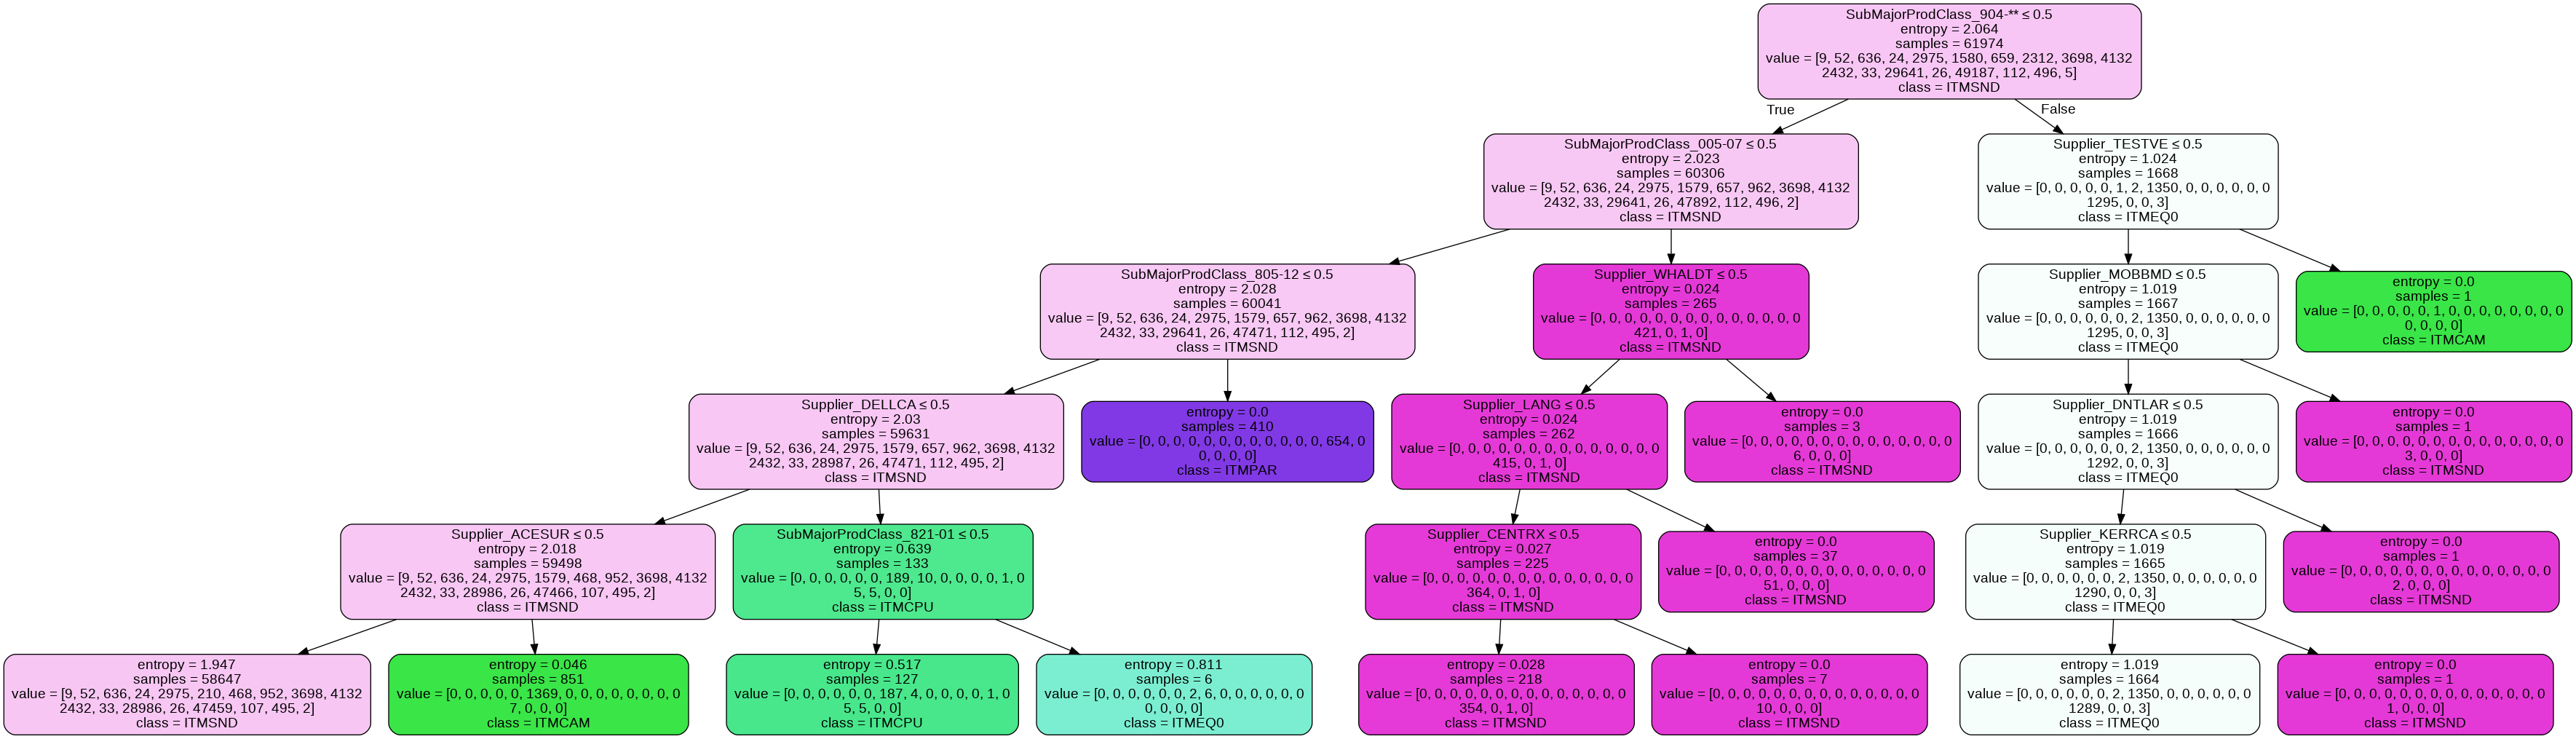

In [21]:
Image(filename='../figures/tree.png')

In [22]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Supplier_ACESUR      Importance: 0.1039
Variable: SubMajorProdClass_805-14 Importance: 0.0803
Variable: SubMajorProdClass_904-** Importance: 0.0757
Variable: Supplier_SIRONC      Importance: 0.0691
Variable: SubMajorProdClass_800-02 Importance: 0.0572
Variable: SubMajorProdClass_805-70 Importance: 0.056
Variable: Supplier_MCC         Importance: 0.0523
Variable: SubMajorProdClass_372-02 Importance: 0.0485
Variable: SubMajorProdClass_010-03 Importance: 0.0298
Variable: Supplier_IVOCZA      Importance: 0.0291
Variable: SubMajorProdClass_805-95 Importance: 0.0272
Variable: Supplier_PELTON      Importance: 0.0267
Variable: SubMajorProdClass_805-40 Importance: 0.0258
Variable: Supplier_DCI         Importance: 0.0251
Variable: SubMajorProdClass_805-80 Importance: 0.0241
Variable: SubMajorProdClass_800-04 Importance: 0.0204
Variable: SubMajorProdClass_071-01 Importance: 0.0202
Variable: Supplier_AMAGIR      Importance: 0.019
Variable: SubMajorProdClass_372-07 Importance: 0.0166
Vari

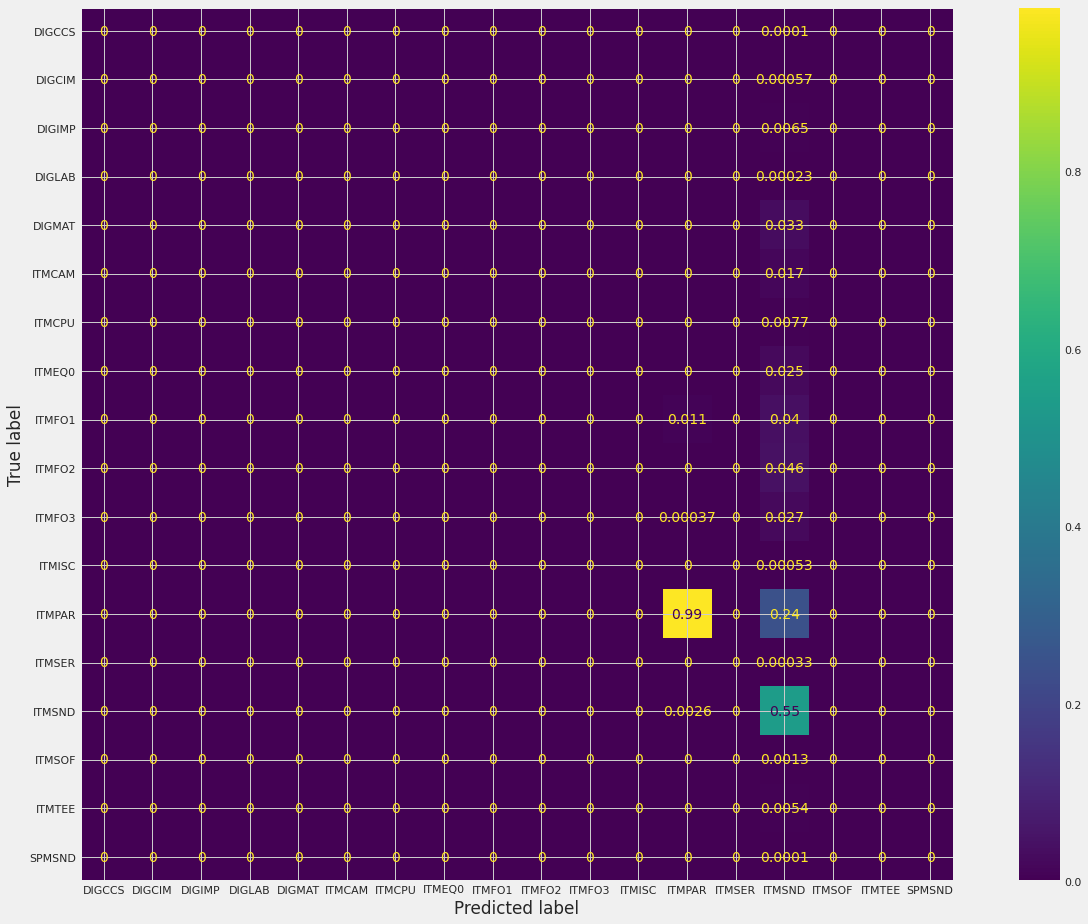

In [23]:
from sklearn.metrics import plot_confusion_matrix
label_list = list(labels_dict_rev.keys())
#plot_confusion_matrix(rf, test_important, test_labels, display_labels = label_list, normalize='pred')
plot_confusion_matrix(rf, test_features, test_labels, display_labels = label_list, normalize='pred')
plt.savefig('../figures/cm06.png')

In [24]:
from sklearn.metrics import confusion_matrix
np.set_printoptions(linewidth=400)
y_true = df['comm_group_cd']
y_pred = df['comm_group_cd_baseline']
print(label_list)
confusion_matrix(y_true, y_pred, labels=label_list )

['DIGCCS', 'DIGCIM', 'DIGIMP', 'DIGLAB', 'DIGMAT', 'ITMCAM', 'ITMCPU', 'ITMEQ0', 'ITMFO1', 'ITMFO2', 'ITMFO3', 'ITMISC', 'ITMPAR', 'ITMSER', 'ITMSND', 'ITMSOF', 'ITMTEE', 'SPMSND']


array([[    6,     0,     3,     1,     0,     0,     0,     0,     0,     2,     0,     0,     0,     0,     0,     0,     0,     0],
       [    0,    62,     1,     3,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
       [    3,     5,   677,     1,     2,     0,     1,    64,     0,     2,     2,     0,     3,     0,    21,     0,     0,     0],
       [    0,     9,     0,    19,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
       [    0,     0,     5,     0,  3598,     0,     0,     0,     0,     0,     0,     0,     0,     0,   309,     0,     0,     0],
       [    0,     0,     0,     0,     0,  1954,     0,     0,     0,    16,     2,     0,     2,     0,    34,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,   876,     4,     2,     8,    21,     0,     1,     1,     0,     5,     0,     0],
       [   11,     1,   108,     0,     3,     1,    11

In [25]:
df.to_csv('../data/item_model_20200627-out.txt', sep='\t')
df_baseline.to_csv('../data/item_model_20200627-out.txt', sep='\t')

# Conclusions

1. Commision cleanup needed to reflect reclassed product
1. Equipment Product Classification cleanup needed for under 90% predictors

## Next steps

Review:
1. where model is false but baseline is true
1. where both model and baseline are false
1. revise model with findings

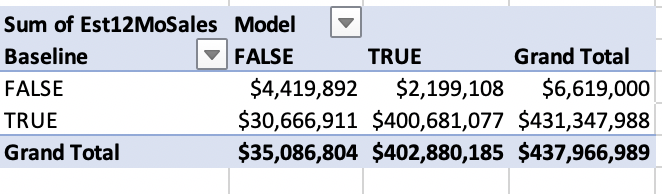